<a href="https://colab.research.google.com/github/Rohanmax/SparkDummyApplication/blob/master/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=cdd01b11bd0a00225f7bffda66c09135b2760e8ad178a9e8f1393ba22267ee91
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import *

In [3]:
my_conf = SparkConf()
my_conf.set("spark.app.name", "my first application")
my_conf.set("spark.master", "local[*]")

In [4]:
spark = SparkSession.builder.config(conf=my_conf).getOrCreate()

In [5]:
readerDf = spark.read.format("csv")\
    .option("header",True)\
    .option("inferSchema",True)\
    .option("path","/content/analytics_input.csv" )\
    .load()

In [6]:
readerDf.printSchema()

root
 |-- DRG Definition: string (nullable = true)
 |-- Provider Id: string (nullable = true)
 |-- Provider Name: string (nullable = true)
 |-- Provider Street Address: string (nullable = true)
 |-- Provider City: string (nullable = true)
 |-- Provider State: string (nullable = true)
 |-- Provider Zip Code: integer (nullable = true)
 |-- Hospital Referral Region Description: string (nullable = true)
 |--  Total Discharges : integer (nullable = true)
 |--  Average Covered Charges : string (nullable = true)
 |--  Average Total Payments : string (nullable = true)
 |-- Average Medicare Payments: string (nullable = true)



In [7]:
columnNameChanged = readerDf.withColumnRenamed("DRG Definition", "drg_definition")\
                    .withColumnRenamed("Provider Id", "provider_id") \
                    .withColumnRenamed("Provider Name", "provider_name")\
                    .withColumnRenamed("Provider Street Address", "provider_street_address")\
                    .withColumnRenamed("Provider City", "provider_city")\
                    .withColumnRenamed("Provider State", "provider_state")\
                    .withColumnRenamed("Provider Zip Code", "provider_zip_code")\
                    .withColumnRenamed("Hospital Referral Region Description", "hospital_referral_region_description")\
                    .withColumnRenamed(" Total Discharges ", "total_discharges")\
	                .withColumnRenamed(" Average Covered Charges ", "average_covered_charges")\
	                .withColumnRenamed(" Average Total Payments ", "average_total_payments")\
	                .withColumnRenamed("Average Medicare Payments", "average_medicare_payments")

In [8]:
filtered = columnNameChanged.filter("provider_id is not null")

In [9]:
dataframe = filtered.withColumn("average_covered_charges", regexp_replace(filtered["average_covered_charges"],"\\$",""))\
                    .withColumn("average_total_payments", regexp_replace(filtered["average_total_payments"],"\\$",""))\
                    .withColumn("average_medicare_payments", regexp_replace(filtered["average_medicare_payments"],"\\$",""))

In [10]:
castToInt = dataframe.withColumn("average_covered_charges",col("average_covered_charges").cast("int"))\
                        .withColumn("average_total_payments",col("average_total_payments").cast("int"))\
                        .withColumn("average_medicare_payments",col("average_medicare_payments").cast("int"))

In [11]:
import pandas as pd

In [12]:
df= castToInt.limit(10).toPandas()

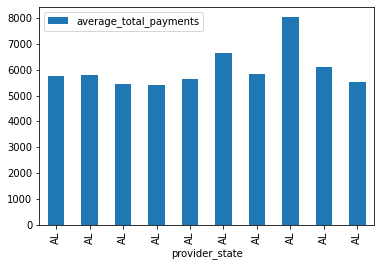

In [13]:
df.plot.bar(x = "provider_state", y="average_total_payments")

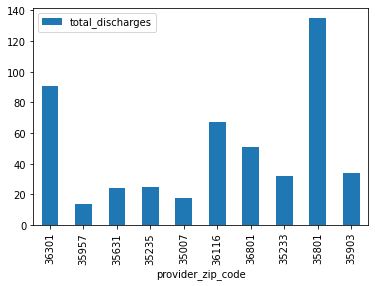

In [14]:
df.plot.bar(x = "provider_zip_code", y="total_discharges")

In [15]:
castToInt.write\
        .partitionBy("provider_state")\
        .mode("Overwrite")\
        .option("path", "/content/write")\
        .save()